In [ ]:
import datetime

import cv2
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [ ]:
import cv2
import numpy as np
from tensorflow.keras import optimizers, models
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
# import matplotlib.pyplot as plt
# Match contours to license plate or character template
from tensorflow.python.keras import Sequential


def find_contours(dimensions, img):
    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs:
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height:
            x_cntr_list.append(
                intX)  # stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44, 24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY + intHeight, intX:intX + intWidth]
            char = cv2.resize(char, (20, 40))

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy)  # List that stores the character's binary image (unsorted)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)

    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])  # stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res


# Find characters in the resulting images
def segment_characters(image):
    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3, 3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3, 3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3, :] = 255
    img_binary_lp[:, 0:3] = 255
    img_binary_lp[72:75, :] = 255
    img_binary_lp[:, 330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH / 6,
                  LP_WIDTH / 2,
                  LP_HEIGHT / 10,
                  2 * LP_HEIGHT / 3]

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

In [ ]:
from google.colab import files

#upload data.zip
files.upload()

In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/train/
   creating: data/train/class_M/
  inflating: data/train/class_M/class_M_23.jpg  
  inflating: data/train/class_M/class_M_22.jpg  
  inflating: data/train/class_M/class_M_20.jpg  
  inflating: data/train/class_M/class_M_21.jpg  
  inflating: data/train/class_M/class_M_19.jpg  
  inflating: data/train/class_M/class_M_25.jpg  
  inflating: data/train/class_M/class_M_24.jpg  
  inflating: data/train/class_M/class_M_18.jpg  
  inflating: data/train/class_M/class_M_26.jpg  
  inflating: data/train/class_M/class_M_27.jpg  
  inflating: data/train/class_M/class_M_9.jpg  
  inflating: data/train/class_M/class_M_8.jpg  
  inflating: data/train/class_M/class_M_3.jpg  
  inflating: data/train/class_M/class_M_2.jpg  
  inflating: data/train/class_M/class_M_6.jpg  
  inflating: data/train/class_M/class_M_7.jpg  
  inflating: data/train/class_M/class_M_5.jpg  
  inflating: data/train/class_M/class_M_4.jpg  
  inflating: data/train/class_

In [ ]:


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


train_datagen = ImageDataGenerator(rescale=1. / 255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
    './data/train',  # this is the target directory
    target_size=(28, 28),  # all images will be resized to 28x28
    batch_size=1,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    './data/val',  # this is the target directory
    target_size=(28, 28),  # all images will be resized to 28x28        batch_size=1,
    class_mode='categorical')


model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(24, 24), input_shape=(28, 28, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

# model.load_weights('model/model')
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_acc', 0) > 0.992):
            self.model.stop_training = True


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


batch_size = 1
callbacks = [tensorboard_callback, stop_training_callback()]
model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=80, callbacks=callbacks)
model.summary()
model.save('model/main')


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/80
864/864 [==============================] - 5s 5ms/step - loss: 3.5627 - accuracy: 0.0405 - val_loss: 3.5077 - val_accuracy: 0.0648
Epoch 2/80
864/864 [==============================] - 4s 4ms/step - loss: 3.4884 - accuracy: 0.0718
Epoch 3/80
864/864 [==============================] - 4s 4ms/step - loss: 3.4140 - accuracy: 0.1192
Epoch 4/80
864/864 [==============================] - 4s 5ms/step - loss: 3.3476 - accuracy: 0.1343
Epoch 5/80
864/864 [==============================] - 3s 4ms/step - loss: 3.2846 - accuracy: 0.1435
Epoch 6/80
864/864 [==============================] - 4s 4ms/step - loss: 3.1798 - accuracy: 0.1678
Epoch 7/80
864/864 [==============================] - 4s 5ms/step - loss: 3.1227 - accuracy: 0.1944
Epoch 8/80
864/864 [==============================] - 3s 4ms/step - loss: 3.0392 - accuracy: 0.2106
Epoch 9/80
864/864 [==============================] - 4s 4ms/step - loss: 2.9744 - accuracy: 0.2049
Epoch 10/80
864/864 [==============================] - 4s 

In [ ]:
# upload final inference testing image. ./car_plate.png

files.upload()


Saving car_plate.png to car_plate.png


{'car_plate.png': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xe2\x02(ICC_PROFILE\x00\x01\x01\x00\x00\x02\x18\x00\x00\x00\x00\x040\x00\x00mntrRGB XYZ \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00acsp\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\tdesc\x00\x00\x00\xf0\x00\x00\x00trXYZ\x00\x00\x01d\x00\x00\x00\x14gXYZ\x00\x00\x01x\x00\x00\x00\x14bXYZ\x00\x00\x01\x8c\x00\x00\x00\x14rTRC\x00\x00\x01\xa0\x00\x00\x00(gTRC\x00\x00\x01\xa0\x00\x00\x00(bTRC\x00\x00\x01\xa0\x00\x00\x00(wtpt\x00\x00\x01\xc8\x00\x00\x00\x14cprt\x00\x00\x01\xdc\x00\x00\x00<mluc\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x0cenUS\x00\x00\x00X\x00\x00\x00\x1c\x00s\x00R\x00G\

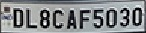

In [ ]:
from google.colab.patches import cv2_imshow

img = cv2.imread('./car_plate.png')
cv2_imshow(img)

In [ ]:

char = segment_characters(img)
def fix_dimension(img):
    new_img = np.zeros((28, 28, 3))
    for i in range(3):
        new_img[:, :, i] = img
    return new_img

def show_results(model, char):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(char):  # iterating over the characters
        img_ = cv2.resize(ch, (28, 28))
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3)  # preparing image for the model
        y_ = np.argmax(model.predict(img), axis=1)[0] # predicting the class
        character = dic[y_]  #
        output.append(character)  # storing the result in a list

    plate_number = ''.join(output)

    return plate_number
show_results(model, char)

'0L8CAF5030'